In [1]:
# load in the data
import pandas as pd
#track_log = pd.read_csv('../../Dataset/train/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'], skiprows=1)
#track1_log = pd.read_csv('../../Dataset/test/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'], skiprows=1)
#track_log = pd.read_csv('../../data4/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'], skiprows=1)
track_log = pd.read_csv('../../data5/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'], skiprows=1)

#combine track1 and track2 data
#combine = [track_log, track1_log]
#make the combine ignore the index number
#track_log = pd.concat(combine, ignore_index=True) 

print(track_log.shape)

(8320, 7)


In [2]:
#load in the img by csv_data
import cv2
import numpy as np

def load_in_img(img_location):
    
    #folder name has save in img_location
    imageLocation = '../../'+img_location
    image = cv2.imread(imageLocation,cv2.IMREAD_COLOR) # BGR

    if (image is None):
        print(imageLocation)
        
    image = image[45:-9,::]
    image = cv2.resize(image, (200,66), fx=0, fy=0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB
    return image

numSample = 50
centerImgs = np.array([load_in_img(img_location) for img_location in track_log['Center'][0:numSample]], dtype=np.float32)
leftImgs = np.array([load_in_img(img_location) for img_location in track_log['Left'][0:numSample]], dtype=np.float32)
rightImgs = np.array([load_in_img(img_location) for img_location in track_log['Right'][0:numSample]], dtype=np.float32) 


In [3]:
#check the image size
print(centerImgs.shape)
print(leftImgs.shape)
print(rightImgs.shape)

(50, 66, 200, 3)
(50, 66, 200, 3)
(50, 66, 200, 3)


In [4]:
#data augmentation
import cv2
import numpy as np

# flip images horizontally
def random_flip_image(img, angle):
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        angle = -angle
    return img, angle

def modify_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    brightness_mul = np.random.uniform(low=0.3, high=1.0)
    img[:,:,2] = img[:,:,2]*brightness_mul
    img[:,:,2][img[:,:,2]>255] = 255
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

def random_shadow(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 200 * np.random.rand(), 0
    x2, y2 = 200 * np.random.rand(), 66
    xm, ym = np.mgrid[0:66, 0:200]
    
    # create the mask area
    mask = np.zeros_like(img[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    random_bright = np.random.uniform(low=0.2, high=0.7)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    img[:, :, 1][cond] = img[:, :, 1][cond] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    return img

def random_translate(img, angle, range_x=100, range_y=10):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = img.shape[:2]
    img = cv2.warpAffine(img, trans_m, (width, height))
    return img, angle

def process_image(img, angle):
    img = modify_brightness(img)
    img = random_shadow(img)
    img, angle = random_flip_image(img, angle)
    img, angle = random_translate(img, angle)
    return img, angle

In [5]:
import sklearn

#load in the img and angle data
def load_data(img_sample, ang_sample, correction = 0.20):

    img_center = load_in_img(img_sample)
    img_left = load_in_img(img_sample)
    img_right =load_in_img(img_sample)
    
    angle_center = float(ang_sample) * (1 + np.random.uniform(-0.10,0.10))
    angle_left = angle_center + correction
    angle_right = angle_center - correction

    return (img_center, img_left, img_right), (angle_center, angle_left, angle_right)

#Generator
def generator(samples, batch_size=64):
    num_samples = len(samples)
    while 1: 
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]       
            images = []
            angles = []
            for img, ang in zip(batch_samples['Center'], batch_samples['Steering Angle']):
                image, angle = load_data(img, ang)
                for item in zip(image,angle): #iterate camera images and steering angles
                    #print(item[0])
                    aug_image, aug_angle = process_image(item[0], item[1])
                    if abs(aug_angle) > 0.05:
                        images.append(aug_image)
                        angles.append(aug_angle)
                        #print(aug_image.shape)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

In [6]:
#split the log into train_samples and validation_samples
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(track_log, test_size=0.2)


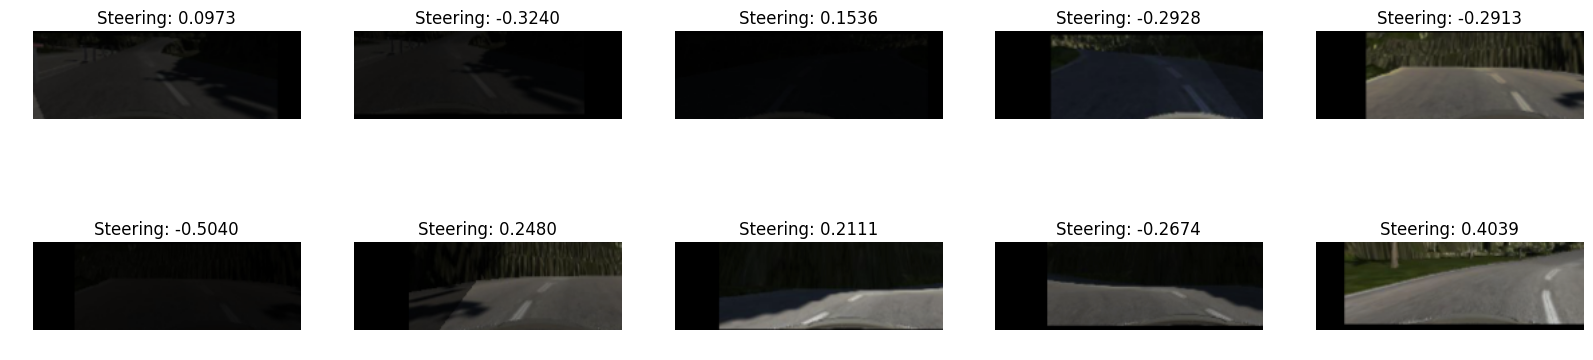

In [7]:
#see if generator work
import matplotlib.pyplot as plt
iterator = generator(train_samples, 64)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(sample_images[i])
plt.show()


In [8]:
#NVIDIA's model
import pickle
import numpy as np
import math
from keras.utils import np_utils
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.models import Sequential

INPUT_SHAPE = (66, 200, 3)
DROP_PROB = 0.7

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0,input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Dropout(DROP_PROB))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


Using TensorFlow backend.


In [9]:
# model summary 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [10]:
model.compile(optimizer="adam", loss="mse")

#assign the specific GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 自動增長 GPU 記憶體用量
#import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
import keras

# compile and train the model using the generator function


for time in range(10):
    train_generator = generator(train_samples, 64)
    validation_generator = generator(validation_samples, 64)
    
    history_object = model.fit_generator(
                                     train_generator, 
                                     samples_per_epoch=32000,
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=10,
                                     verbose=2,
                                     callbacks=[
                                         ModelCheckpoint(filepath="time"+str(time)+".h5", verbose=1, save_best_only=True),
                                         keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
                                     ])
    
    
    print('Time ',time+1)



Epoch 1/10


/opt/miniconda/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.14751, saving model to time0.h5
44s - loss: 0.1776 - val_loss: 0.1475
Epoch 2/10
Epoch 00001: val_loss did not improve
41s - loss: 0.1561 - val_loss: 0.1516
Epoch 3/10
Epoch 00002: val_loss improved from 0.14751 to 0.13501, saving model to time0.h5
41s - loss: 0.1533 - val_loss: 0.1350
Epoch 4/10
Epoch 00003: val_loss did not improve
41s - loss: 0.1461 - val_loss: 0.1366
Epoch 5/10
Epoch 00004: val_loss did not improve
41s - loss: 0.1421 - val_loss: 0.1412
Epoch 6/10
Epoch 00005: val_loss improved from 0.13501 to 0.12349, saving model to time0.h5
41s - loss: 0.1358 - val_loss: 0.1235
Epoch 7/10
Epoch 00006: val_loss improved from 0.12349 to 0.11394, saving model to time0.h5
41s - loss: 0.1278 - val_loss: 0.1139
Epoch 8/10
Epoch 00007: val_loss improved from 0.11394 to 0.11144, saving model to time0.h5
42s - loss: 0.1223 - val_loss: 0.1114
Epoch 9/10
Epoch 00008: val_loss improved from 0.11144 to 0.10112, saving model to time0.h5
42s - loss: 

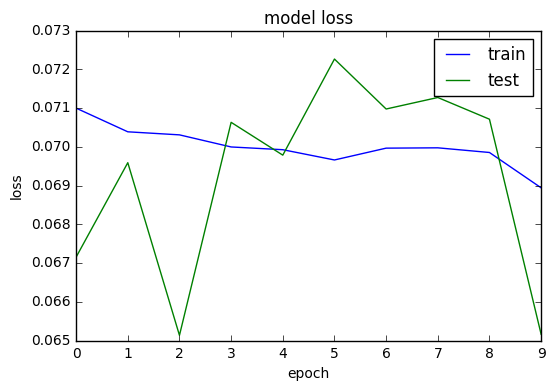

In [12]:
# summarize history for loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [13]:
import time, os, fnmatch, shutil
def save_model(model_name):
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H-%M-%S', t)
    model_name = ('model' + model_name  + '_' + timestamp + '.h5')
    
    return model_name

h5_output = save_model("CNN_model") 
model.save(h5_output)
print("Model saved")

Model saved


In [ ]:
#data selection -> make the zero Steering Angle less
#idea from : https://github.com/budmitr
non_zero_samples =  training_log.loc[training_log['Steering Angle'] != 0.0,:] 
zero_samples =  training_log.loc[training_log['Steering Angle'] == 0.0,:]  # 
print(training_log.shape, non_zero_samples.shape, zero_samples.shape) 

fraction = 0.2
new_training_log = pd.concat([non_zero_samples, zero_samples.sample(frac=fraction)], ignore_index=True)

#print(newDrivingLog)
training_log = new_training_log

print(training_log['Steering Angle'].shape)

In [ ]:
# save the model
import json
#import simplejson
jsonString = model.to_json() # json Model
with open('./model.json', 'w') as outFile:
    outFile.write(jsonString)
    # json.dump(jsonString, outFile)

model.save_weights('./model.h5') #  HDF5 file

In [ ]:
# load the model
from keras.models import model_from_json
jsonFile = './model.json'
with open(jsonFile, 'r') as jfile:
    #model = model_from_json(json.load(jfile))
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
weights_file = jsonFile.replace('json', 'h5')
model.load_weights(weights_file)